In [1]:
import sys
from comet_ml import Experiment
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary

# Local imports
sys.path.append("/Users/leo/Programming/Thesis/utils")
sys.path.append("/Users/leo/Programming/Thesis/models")

from helper_functions import (delete_ds_store,plot_metrics,test,train,mean_std_finder,load_model)
from GhostNetCBAM import ghost_net
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": "CBAM",
    "module_alias": "GhostNetCBAM",
    "data_path": "/Users/leo/Programming/Thesis/data/ImageNet_25/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 25,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": "mps",
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = ghost_net(num_classes=prms["num_classes"])
delete_ds_store(prms["data_path"])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/imagenet-25/a2f8e8fcd9954bac970c6a240db44141



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
#mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729]) # VGG
mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225]) # ImageNet
print(f"Mean: {mean}, Std: {std}")  

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

Mean: tensor([0.4850, 0.4560, 0.4060]), Std: tensor([0.2290, 0.2240, 0.2250])


In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


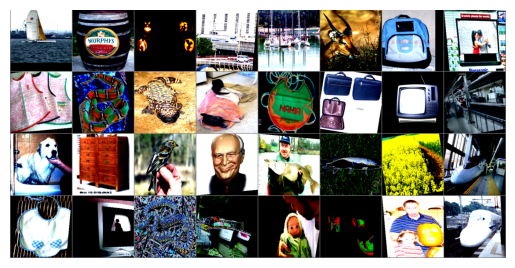

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
# set the seed for reproducibility
torch.manual_seed(42)

dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = prms["model"].to(prms["device"])

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

In [7]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
GhostNetCBAM (GhostNetCBAM)                                  [1, 3, 224, 224]     [1, 25]              --                   --                   --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 96, 7, 7]        --                   --                   --                   True
│    └─Sequential (0)                                        [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    32                   --              

100%|██████████| 153/153 [00:32<00:00,  4.75it/s]


Epoch: 01 | Epoch Time: 5.0m 48s
	Train Loss: 2.677 | Train Acc: 22.07%
	 Val. Loss: 2.180 |  Val. Acc: 34.61%
Best Accuracy Achieved: 34.61% on epoch 01


100%|██████████| 153/153 [00:30<00:00,  5.10it/s]


Epoch: 02 | Epoch Time: 5.0m 16s
	Train Loss: 2.344 | Train Acc: 29.89%
	 Val. Loss: 1.917 |  Val. Acc: 41.81%
Best Accuracy Achieved: 41.81% on epoch 02


100%|██████████| 153/153 [00:30<00:00,  5.10it/s]


Epoch: 03 | Epoch Time: 5.0m 21s
	Train Loss: 2.055 | Train Acc: 37.74%
	 Val. Loss: 1.781 |  Val. Acc: 45.07%
Best Accuracy Achieved: 45.07% on epoch 03


100%|██████████| 153/153 [00:30<00:00,  5.08it/s]


Epoch: 04 | Epoch Time: 5.0m 20s
	Train Loss: 1.888 | Train Acc: 42.95%
	 Val. Loss: 1.596 |  Val. Acc: 51.14%
Best Accuracy Achieved: 51.14% on epoch 04


100%|██████████| 153/153 [00:30<00:00,  5.10it/s]


Epoch: 05 | Epoch Time: 5.0m 17s
	Train Loss: 1.775 | Train Acc: 46.79%
	 Val. Loss: 1.538 |  Val. Acc: 52.64%
Best Accuracy Achieved: 52.64% on epoch 05


100%|██████████| 153/153 [00:29<00:00,  5.10it/s]


Epoch: 06 | Epoch Time: 5.0m 17s
	Train Loss: 1.638 | Train Acc: 50.58%
	 Val. Loss: 1.422 |  Val. Acc: 56.21%
Best Accuracy Achieved: 56.21% on epoch 06


100%|██████████| 153/153 [00:29<00:00,  5.14it/s]


Epoch: 07 | Epoch Time: 5.0m 18s
	Train Loss: 1.559 | Train Acc: 53.35%
	 Val. Loss: 1.337 |  Val. Acc: 58.54%
Best Accuracy Achieved: 58.54% on epoch 07


100%|██████████| 153/153 [00:29<00:00,  5.19it/s]


Epoch: 08 | Epoch Time: 5.0m 20s
	Train Loss: 1.452 | Train Acc: 56.07%
	 Val. Loss: 1.262 |  Val. Acc: 61.50%
Best Accuracy Achieved: 61.50% on epoch 08


100%|██████████| 153/153 [00:29<00:00,  5.15it/s]


Epoch: 09 | Epoch Time: 5.0m 18s
	Train Loss: 1.375 | Train Acc: 58.07%
	 Val. Loss: 1.309 |  Val. Acc: 59.69%


100%|██████████| 153/153 [00:26<00:00,  5.67it/s]


Epoch: 10 | Epoch Time: 5.0m 16s
	Train Loss: 1.307 | Train Acc: 59.98%
	 Val. Loss: 1.226 |  Val. Acc: 62.71%
Best Accuracy Achieved: 62.71% on epoch 10


100%|██████████| 153/153 [00:29<00:00,  5.16it/s]


Epoch: 11 | Epoch Time: 5.0m 18s
	Train Loss: 1.240 | Train Acc: 62.50%
	 Val. Loss: 1.144 |  Val. Acc: 65.44%
Best Accuracy Achieved: 65.44% on epoch 11


100%|██████████| 153/153 [00:29<00:00,  5.14it/s]


Epoch: 12 | Epoch Time: 5.0m 18s
	Train Loss: 1.194 | Train Acc: 64.00%
	 Val. Loss: 1.100 |  Val. Acc: 66.71%
Best Accuracy Achieved: 66.71% on epoch 12


100%|██████████| 153/153 [00:29<00:00,  5.25it/s]


Epoch: 13 | Epoch Time: 5.0m 16s
	Train Loss: 1.128 | Train Acc: 65.78%
	 Val. Loss: 1.073 |  Val. Acc: 68.55%
Best Accuracy Achieved: 68.55% on epoch 13


100%|██████████| 153/153 [00:29<00:00,  5.15it/s]


Epoch: 14 | Epoch Time: 5.0m 12s
	Train Loss: 1.084 | Train Acc: 66.76%
	 Val. Loss: 1.061 |  Val. Acc: 68.47%


100%|██████████| 153/153 [00:29<00:00,  5.21it/s]


Epoch: 15 | Epoch Time: 5.0m 10s
	Train Loss: 1.032 | Train Acc: 68.22%
	 Val. Loss: 1.050 |  Val. Acc: 68.49%


100%|██████████| 153/153 [00:30<00:00,  5.09it/s]


Epoch: 16 | Epoch Time: 5.0m 14s
	Train Loss: 1.003 | Train Acc: 69.35%
	 Val. Loss: 1.078 |  Val. Acc: 68.06%


100%|██████████| 153/153 [00:29<00:00,  5.21it/s]


Epoch: 17 | Epoch Time: 5.0m 11s
	Train Loss: 0.973 | Train Acc: 69.95%
	 Val. Loss: 1.026 |  Val. Acc: 69.48%
Best Accuracy Achieved: 69.48% on epoch 17


100%|██████████| 153/153 [00:29<00:00,  5.21it/s]


Epoch: 18 | Epoch Time: 5.0m 11s
	Train Loss: 0.943 | Train Acc: 70.38%
	 Val. Loss: 0.976 |  Val. Acc: 71.24%
Best Accuracy Achieved: 71.24% on epoch 18


100%|██████████| 153/153 [00:28<00:00,  5.38it/s]


Epoch: 19 | Epoch Time: 5.0m 14s
	Train Loss: 0.897 | Train Acc: 72.13%
	 Val. Loss: 1.020 |  Val. Acc: 70.32%


100%|██████████| 153/153 [00:30<00:00,  5.04it/s]


Epoch: 20 | Epoch Time: 5.0m 12s
	Train Loss: 0.864 | Train Acc: 73.11%
	 Val. Loss: 0.974 |  Val. Acc: 71.84%
Best Accuracy Achieved: 71.84% on epoch 20


100%|██████████| 153/153 [00:29<00:00,  5.13it/s]


Epoch: 21 | Epoch Time: 5.0m 25s
	Train Loss: 0.826 | Train Acc: 74.23%
	 Val. Loss: 1.014 |  Val. Acc: 70.58%


100%|██████████| 153/153 [00:30<00:00,  4.97it/s]


Epoch: 22 | Epoch Time: 5.0m 24s
	Train Loss: 0.820 | Train Acc: 74.40%
	 Val. Loss: 0.963 |  Val. Acc: 72.08%
Best Accuracy Achieved: 72.08% on epoch 22


100%|██████████| 153/153 [00:30<00:00,  5.00it/s]


Epoch: 23 | Epoch Time: 5.0m 26s
	Train Loss: 0.792 | Train Acc: 75.34%
	 Val. Loss: 0.980 |  Val. Acc: 71.84%


100%|██████████| 153/153 [00:30<00:00,  5.03it/s]


Epoch: 24 | Epoch Time: 5.0m 25s
	Train Loss: 0.736 | Train Acc: 77.19%
	 Val. Loss: 1.036 |  Val. Acc: 71.06%


100%|██████████| 153/153 [00:30<00:00,  5.03it/s]


Epoch: 25 | Epoch Time: 5.0m 25s
	Train Loss: 0.743 | Train Acc: 76.65%
	 Val. Loss: 0.954 |  Val. Acc: 72.98%
Best Accuracy Achieved: 72.98% on epoch 25


100%|██████████| 153/153 [00:30<00:00,  4.98it/s]


Epoch: 26 | Epoch Time: 5.0m 24s
	Train Loss: 0.702 | Train Acc: 78.20%
	 Val. Loss: 0.949 |  Val. Acc: 72.82%


100%|██████████| 153/153 [00:31<00:00,  4.90it/s]


Epoch: 27 | Epoch Time: 5.0m 26s
	Train Loss: 0.686 | Train Acc: 78.44%
	 Val. Loss: 0.960 |  Val. Acc: 72.80%


100%|██████████| 153/153 [00:31<00:00,  4.91it/s]


Epoch: 28 | Epoch Time: 5.0m 26s
	Train Loss: 0.674 | Train Acc: 78.89%
	 Val. Loss: 1.092 |  Val. Acc: 70.65%


100%|██████████| 153/153 [00:30<00:00,  5.03it/s]


Epoch: 29 | Epoch Time: 5.0m 23s
	Train Loss: 0.654 | Train Acc: 79.46%
	 Val. Loss: 0.972 |  Val. Acc: 73.54%
Best Accuracy Achieved: 73.54% on epoch 29


100%|██████████| 153/153 [00:30<00:00,  4.99it/s]


Epoch: 30 | Epoch Time: 5.0m 23s
	Train Loss: 0.631 | Train Acc: 80.07%
	 Val. Loss: 0.972 |  Val. Acc: 72.55%


100%|██████████| 153/153 [00:30<00:00,  5.01it/s]


Epoch: 31 | Epoch Time: 5.0m 21s
	Train Loss: 0.624 | Train Acc: 80.22%
	 Val. Loss: 1.021 |  Val. Acc: 71.79%


100%|██████████| 153/153 [00:28<00:00,  5.29it/s]


Epoch 00032: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 32 | Epoch Time: 5.0m 22s
	Train Loss: 0.604 | Train Acc: 80.94%
	 Val. Loss: 1.053 |  Val. Acc: 72.23%


100%|██████████| 153/153 [00:30<00:00,  5.01it/s]


Epoch: 33 | Epoch Time: 5.0m 22s
	Train Loss: 0.376 | Train Acc: 88.03%
	 Val. Loss: 0.871 |  Val. Acc: 77.23%
Best Accuracy Achieved: 77.23% on epoch 33


100%|██████████| 153/153 [00:30<00:00,  5.02it/s]


Epoch: 34 | Epoch Time: 5.0m 19s
	Train Loss: 0.334 | Train Acc: 89.42%
	 Val. Loss: 0.889 |  Val. Acc: 77.58%
Best Accuracy Achieved: 77.58% on epoch 34


100%|██████████| 153/153 [00:30<00:00,  4.96it/s]


Epoch: 35 | Epoch Time: 5.0m 24s
	Train Loss: 0.309 | Train Acc: 90.31%
	 Val. Loss: 0.910 |  Val. Acc: 77.46%


100%|██████████| 153/153 [00:30<00:00,  5.02it/s]


Epoch: 36 | Epoch Time: 5.0m 26s
	Train Loss: 0.293 | Train Acc: 90.84%
	 Val. Loss: 0.919 |  Val. Acc: 77.46%


100%|██████████| 153/153 [00:31<00:00,  4.89it/s]


Epoch: 37 | Epoch Time: 5.0m 22s
	Train Loss: 0.278 | Train Acc: 91.13%
	 Val. Loss: 0.927 |  Val. Acc: 77.52%


100%|██████████| 153/153 [00:32<00:00,  4.68it/s]


Epoch: 38 | Epoch Time: 5.0m 25s
	Train Loss: 0.262 | Train Acc: 91.60%
	 Val. Loss: 0.945 |  Val. Acc: 77.52%


100%|██████████| 153/153 [00:30<00:00,  4.97it/s]


Epoch 00039: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 39 | Epoch Time: 5.0m 27s
	Train Loss: 0.254 | Train Acc: 92.03%
	 Val. Loss: 0.953 |  Val. Acc: 77.46%


100%|██████████| 153/153 [00:29<00:00,  5.16it/s]


Epoch: 40 | Epoch Time: 5.0m 21s
	Train Loss: 0.235 | Train Acc: 92.73%
	 Val. Loss: 0.948 |  Val. Acc: 77.76%
Best Accuracy Achieved: 77.76% on epoch 40


100%|██████████| 153/153 [00:32<00:00,  4.69it/s]


Epoch: 41 | Epoch Time: 5.0m 26s
	Train Loss: 0.230 | Train Acc: 92.88%
	 Val. Loss: 0.955 |  Val. Acc: 77.89%
Best Accuracy Achieved: 77.89% on epoch 41


100%|██████████| 153/153 [00:31<00:00,  4.89it/s]


Epoch: 42 | Epoch Time: 5.0m 24s
	Train Loss: 0.227 | Train Acc: 92.88%
	 Val. Loss: 0.957 |  Val. Acc: 77.87%


100%|██████████| 153/153 [00:32<00:00,  4.77it/s]


Epoch: 43 | Epoch Time: 5.0m 27s
	Train Loss: 0.225 | Train Acc: 93.18%
	 Val. Loss: 0.959 |  Val. Acc: 77.83%


100%|██████████| 153/153 [00:31<00:00,  4.90it/s]


Epoch: 44 | Epoch Time: 5.0m 25s
	Train Loss: 0.230 | Train Acc: 93.04%
	 Val. Loss: 0.960 |  Val. Acc: 77.87%


100%|██████████| 153/153 [00:30<00:00,  5.04it/s]


Epoch 00045: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 45 | Epoch Time: 5.0m 28s
	Train Loss: 0.219 | Train Acc: 93.37%
	 Val. Loss: 0.961 |  Val. Acc: 77.97%
Best Accuracy Achieved: 77.97% on epoch 45


100%|██████████| 153/153 [00:29<00:00,  5.11it/s]


Epoch: 46 | Epoch Time: 5.0m 4s
	Train Loss: 0.218 | Train Acc: 93.18%
	 Val. Loss: 0.962 |  Val. Acc: 77.89%


100%|██████████| 153/153 [00:29<00:00,  5.17it/s]


Epoch: 47 | Epoch Time: 4.0m 54s
	Train Loss: 0.228 | Train Acc: 92.92%
	 Val. Loss: 0.962 |  Val. Acc: 77.95%


100%|██████████| 153/153 [00:29<00:00,  5.27it/s]


Epoch: 48 | Epoch Time: 4.0m 55s
	Train Loss: 0.226 | Train Acc: 93.09%
	 Val. Loss: 0.962 |  Val. Acc: 77.97%


100%|██████████| 153/153 [00:30<00:00,  5.04it/s]


Epoch: 49 | Epoch Time: 4.0m 57s
	Train Loss: 0.229 | Train Acc: 92.87%
	 Val. Loss: 0.963 |  Val. Acc: 77.93%


100%|██████████| 153/153 [00:28<00:00,  5.29it/s]


Epoch: 50 | Epoch Time: 4.0m 49s
	Train Loss: 0.220 | Train Acc: 93.13%
	 Val. Loss: 0.963 |  Val. Acc: 77.99%
Best Accuracy Achieved: 77.99% on epoch 50


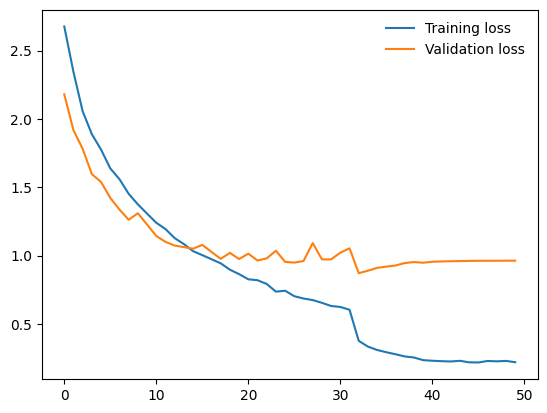

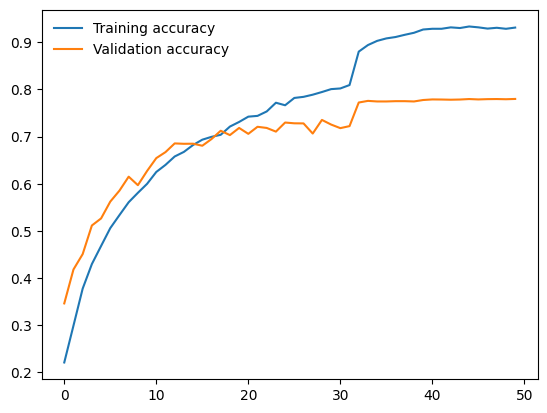

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

In [9]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/imagenet-25/a2f8e8fcd9954bac970c6a240db44141
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     flops           : 45932198.0
COMET INFO:     inference_time  : 0.006150153233454777
COMET INFO:     loss [3605]     : (0.00461517134681344, 9.67081356048584)
COMET INFO:     params          : 1155371.0
COMET INFO:     test_accuracy   : 0.7725127935409546
COMET INFO:     test_loss       : 1.0536988837460821
COMET INFO:     train_acc [50]  : (0.22070330381393433, 0.9336703419685364)
COMET INFO:     train_loss [50] : (0.21752672866281572, 2.6766565519898804)
COMET INFO:     val_acc [50]    : (0.34605127573013306

Test loss: 1.054.. 
Test accuracy: 0.773
Test Time: 0.0m 29s 981ms


─────────────────────────────────────────────── New Comet feature! ───────────────────────────────────────────────
Log your models to better track, deploy, share, and reproduce your work using: 'comet_ml.integration.pytorch.log_model'.
Learn more at: https://comet.com/docs/v2/pytorch_log_model

Hide this message by setting environment variable "COMET_DISABLE_ANNOUNCEMENT=1" 
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)


(1.0536988837460821, tensor(0.7725, device='mps:0'))